In [2]:
import spotipy
import os
import sys 
import webbrowser
import spotipy.util as util
from json.decoder import JSONDecodeError
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import preprocessing
import math

# Clustering saved songs into playlists

A client ID and client password is required to get authorization for Spotipy. You will have to register your app at https://developer.spotify.com/dashboard/login under 'My Dashboard' to get your personal client_ID and client_secret. Edit app settings to set the redirect_uri as https://google.com/. 

Since we want to accesss our saved songs, we set the scope as 'user-library-read'. After running the cell, you will be redirected to the site you set as 'redirect_uri'. Copy the link of the site after you are redirected and paste the link where prompted below this cell. 

#### Important note: I have removed any personal user or account information (username, client_id, client_secret). If you wish to replicate this project, make sure you fill in those variables with your own credentials.

Use client ID and client secret to get authorization to access Spotify data. Set the scope. Since we want to accesss the user's saved songs, we set the scope as 'user-library-read'. After running the cell, you will be redirected to the site you set as 'redirect_uri'. Copy the link of the site after you are redirected and paste the link where prompted below this cell. 

In [ ]:
# Get token for authorization 
import spotipy.util as util

# Enter personal username and ids
username = ''
client_id = ''
client_secret = ''

username = username
scope = 'user-library-read'
client_id = client_id
client_secret = client_secret
redirect_uri='https://google.com/'
token = util.prompt_for_user_token(username,
                           scope,
                           client_id=client_id,
                           client_secret=client_secret,
                           redirect_uri='https://google.com/')

if token:
    sp = spotipy.Spotify(auth=token)

### Populate a dataframe with your saved songs. 

In [48]:
username = ''
num_songs = #specify the number of tracks you currently have saved on Spotify

id_test = sp.user_playlist_tracks(username, 'capjqw9g4pf7ft0ds00y30oxm:playlist:0ZuQXoVLRwcMEgRyi6HxVD')['items'][0]['track']['id']
columns = ['artist', 'track']
list(map(lambda x: columns.append(x), list(sp.audio_features(id_test)[0].keys()))) # Get columns for song features
row_counter = 0

tracks = pd.DataFrame(columns = columns, index = range(0, num_songs)) #Set range to length of saved tracks
tracks["Popularity"] = np.nan # Create a column for popularity
tracks["added_at"] = np.nan # Create a column for date added
 
off = 0
song_list = []
for i in range(0,num_songs):
    track = sp.current_user_saved_tracks(limit=1, offset=off)['items'][0] #Only read one song at a time and increase offset (index) every time
    current_id = track['track']['id']
    current_row = [track['track']['artists'][0]['name'], track['track']['name']] 
    (list(map(lambda x: current_row.append(x), list(sp.audio_features(current_id)[0].values())))) # Use song ID to get song features
    current_row.append(track['track']['popularity'])
    current_row.append(track['added_at'])
    song_list.append(current_row)
    tracks.iloc[i] = current_row
    off += 1

In [49]:
saved_tracks = tracks.copy()
saved_tracks.to_csv("saved_tracks.csv")

# Data Import

In [4]:
saved_tracks = pd.read_csv("saved_tracks.csv", index_col = 0)


# Drop columns that aren't needed for clustering
saved_tracks.drop(['type', 'track_href','analysis_url'], axis = 1, inplace = True)

# Change data types of columns
saved_tracks = saved_tracks.astype({'danceability': float,
                                        'energy': float,
                                        'key': int,
                                        'loudness': float,
                                        'mode': int,
                                        'speechiness': float,
                                        'acousticness': float,
                                        'instrumentalness': float,
                                        'liveness': float,
                                        'valence': float,
                                        'tempo': float,
                                        'duration_ms': float,
                                        'time_signature': float})


# Change the date feature to the datatype date time
saved_tracks['added_at'] = pd.to_datetime(saved_tracks['added_at'])

# Create a columns for month and year
saved_tracks['Month'] = saved_tracks['added_at'].dt.month
saved_tracks['Year'] = saved_tracks['added_at'].dt.year

# Group tracks by month and year
year_month = saved_tracks.groupby(['Year', 'Month']).agg('count')
date = year_month['added_at'].to_frame()
date = date.rename(columns = {'added_at':'num_songs'})

# Exploratory Data Analysis

Examine dataframe and feature characteristics

In [5]:
print(saved_tracks.info())
saved_tracks.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   artist            504 non-null    object             
 1   track             504 non-null    object             
 2   danceability      504 non-null    float64            
 3   energy            504 non-null    float64            
 4   key               504 non-null    int64              
 5   loudness          504 non-null    float64            
 6   mode              504 non-null    int64              
 7   speechiness       504 non-null    float64            
 8   acousticness      504 non-null    float64            
 9   instrumentalness  504 non-null    float64            
 10  liveness          504 non-null    float64            
 11  valence           504 non-null    float64            
 12  tempo             504 non-null    float64            
 13  id   

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Popularity,Month,Year
count,504.00000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
mean,0.69345,0.614244,5.156746,-6.341845,0.545635,0.130371,0.225143,0.005693,0.171642,0.445851,120.687687,204149.500000,3.970238,61.771825,7.251984,2019.339286
std,0.14163,0.149118,3.649836,2.218846,0.498408,0.105165,0.227485,0.039041,0.125134,0.200185,28.699409,44719.510664,0.341187,23.331851,3.203191,0.686395
min,0.21800,0.231000,0.000000,-17.540000,0.000000,0.024300,0.000177,0.000000,0.031600,0.035200,59.989000,97297.000000,1.000000,0.000000,1.000000,2018.000000
25%,0.61700,0.519750,1.000000,-7.594500,0.000000,0.048750,0.041875,0.000000,0.095075,0.314000,98.031500,175232.250000,4.000000,55.000000,4.000000,2019.000000
50%,0.70450,0.622000,5.000000,-6.157500,1.000000,0.084250,0.152000,0.000000,0.119000,0.435000,117.993000,201996.500000,4.000000,68.000000,8.000000,2019.000000
75%,0.80000,0.716000,8.000000,-4.781000,1.000000,0.195250,0.336750,0.000010,0.208250,0.573000,140.094250,226480.000000,4.000000,77.000000,10.000000,2020.000000
max,0.97400,0.941000,11.000000,-0.938000,1.000000,0.502000,0.946000,0.482000,0.959000,0.939000,203.927000,417920.000000,5.000000,100.000000,12.000000,2020.000000


Observe the relationships between song features with a heatmap

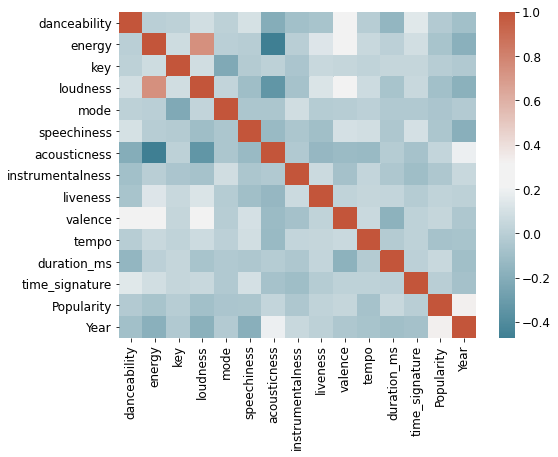

In [54]:
import seaborn as sns
import matplotlib

fig, ax = plt.subplots(figsize = (8,6))
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)

cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(saved_tracks.corr(), cmap = cmap)  

cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=12)

What artists have the most songs in my liked songs?

In [53]:
saved_tracks.artist.value_counts().to_frame()[:10]

,artist
Rihanna,10
Jhené Aiko,10
The Weeknd,8
Cardi B,7
Post Malone,7
G-Eazy,7
Marc E. Bassy,6
Kanye West,6
Drake,6
Megan Thee Stallion,6


What are the highest energy songs that I have saved? (Energy defined by spotify as a measure from 0.0 to 1.0 that represents a perceptual measure of intensity and activity)

In [56]:
saved_tracks.sort_values('energy', ascending = False)[['artist', 'track', 'energy']][:10]

,artist,track,energy
255,Wilkinson,Sweet Lies,0.941
417,GASHI,Creep On Me (feat. French Montana & DJ Snake) ...,0.934
428,Skrillex,HUMBLE. - SKRILLEX REMIX,0.934
357,Lost Kings,Don't Kill My High,0.932
422,RL Grime,UCLA - Heimanu Remix,0.925
409,R3HAB,Up All Night,0.916
479,Big Sean,Ashley,0.915
271,Fabolous,You Be Killin Em,0.909
494,Drake,Nice For What,0.909
398,Gucci Mane,Love Thru The Computer (feat. Justin Bieber),0.908


What are the mean feature values for the 50 most popular songs compared to mean values for all songs?

In [64]:
popular_df = saved_tracks.sort_values(by = 'Popularity', ascending = False)[:50]

means = pd.DataFrame(index = ["Popular", "All"],columns = list(saved_tracks.describe().loc['mean'].index))

means.loc['Popular'] = popular_df.describe().loc['mean']
means.loc['All'] = saved_tracks.describe().loc['mean']
means[['danceability','energy','liveness', 'tempo','Year']]

,danceability,energy,liveness,tempo,Year
Popular,0.67236,0.56882,0.189074,116.435,2019.82
All,0.69345,0.614244,0.171642,120.688,2019.34


Examining my taste in music over time 

In [65]:
# Standardize features
scaler = StandardScaler()
num_cols = ['danceability', 'energy', 'speechiness', 'instrumentalness', 'valence', 'liveness','tempo', 'Popularity']
saved_tracks[num_cols] = scaler.fit_transform(saved_tracks[num_cols])

# Select the features we would like to examine and then aggregate the data by month to get monthly averages.
weekly_means = saved_tracks.set_index(['added_at'])
agg_dict = {'energy': 'mean',
          'danceability': 'mean',
          'liveness': 'mean',
          'tempo' : 'mean',
          'acousticness' : 'mean',
          'instrumentalness' : 'mean',
          'valence':'mean'}

# Create resampled data frame
# 'M' means monthly aggregation
weekly_df = weekly_means.resample('M').agg(agg_dict)

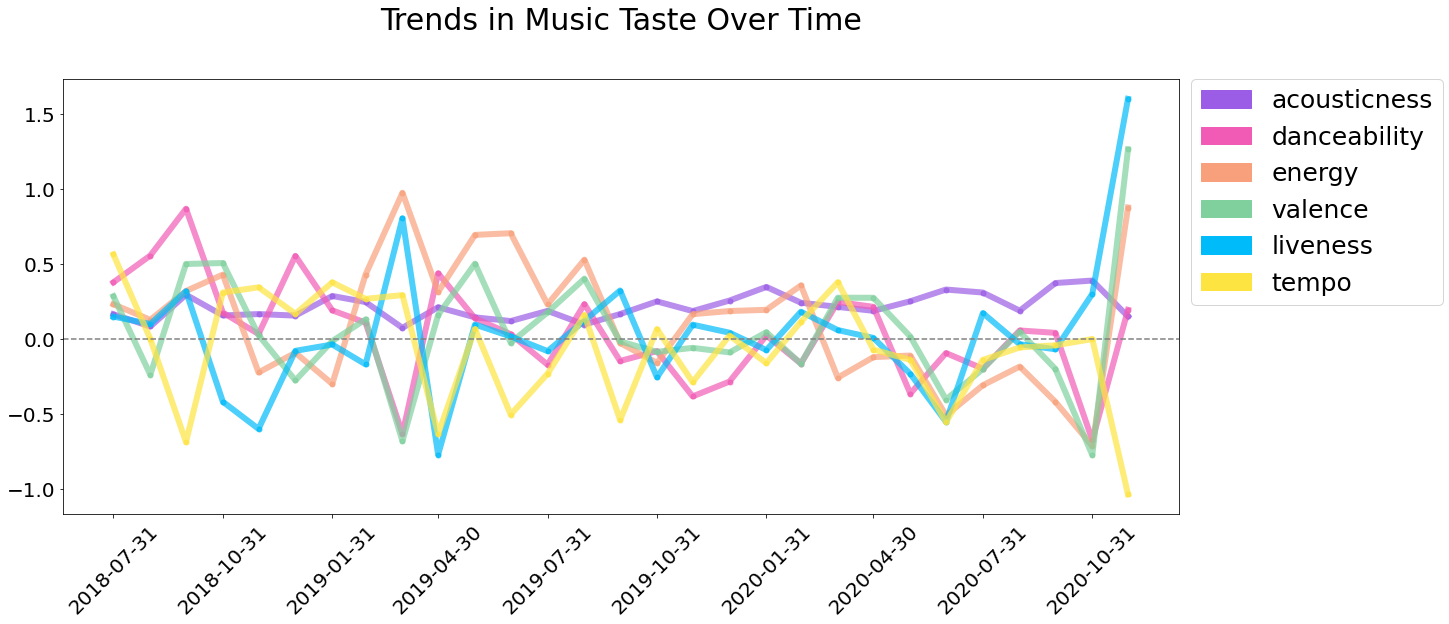

In [77]:
# Graph weekly data
variables = ['acousticness','danceability','energy','valence','liveness','tempo']
color = ['#9B5DE5','#F15BB5','#F8A07B','#7FD09D','#00BBF9','#FEE440']
# color = ['#9B5DE5','#F15BB5','#F8A07B','#FEE440','#7FD09D','#00BBF9','#17F6D8']
fig = plt.figure(figsize=(20,8))
l=[]
import matplotlib.patches as mpatches
for i in range(len(variables)):
    x = str(i)
    x = mpatches.Patch(color=color[i], label=variables[i])
    l.append(x)
    plt.plot(variables[i],data=weekly_df, color=color[i], linewidth=6, alpha=.7, marker='o', markersize=5)
    

plt.legend(handles=l,bbox_to_anchor=(1,1.03), prop = {'size':25})
plt.title("Trends in Music Taste Over Time",y=1.1,fontsize=30)
plt.axhline(y=0, color='grey', linestyle='--')
plt.xticks(weekly_df.index, fontsize= 20, rotation = 45)
plt.yticks(fontsize= 20)

xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 3!= 0:
        xticks[i].set_visible(False)

When were songs added?

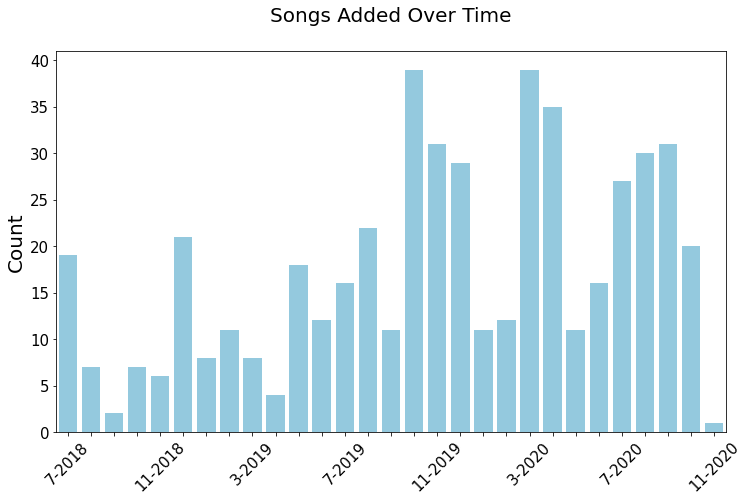

In [79]:
fig, ax = plt.subplots(figsize = (12,7))

fig = sns.barplot(x = date.index.values, y = date.num_songs, data = date, color = 'skyblue')

labels = [f'{i[1]}-{i[0]}' for i in date.index.values]
ax.set_xticklabels(labels = labels,rotation = 45, fontsize = 15)
ax.set_xlabel('')

plt.yticks(fontsize= 15)
ax.set_ylabel(ylabel = 'Count', size = 20)

ax.set_title('Songs Added Over Time', size = 20, pad = 30, fontname = 'sans-serif')

every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        


# K Means Clustering 

### Use the elbow method to find the best K. Try k values 1-21.

In [80]:
# Drop columns not used for modeling
saved_tracks.drop(columns = ["added_at", "Month", "duration_ms"], axis = 0, inplace = True)

# Create dummy variables for Year
onehotencoder = OneHotEncoder()
saved_tracks = pd.get_dummies(saved_tracks, columns = ['Year'])

# Scale features that don't already have values between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
col_features = ['danceability', 'key',
                'energy','loudness', 'tempo', 'Popularity', 'time_signature']
saved_tracks[col_features] = MinMaxScaler().fit_transform(saved_tracks[col_features])

In [81]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,21) 
for k in K:
    model = KMeans(n_clusters=k)
    model = model.fit(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))
    Sum_of_squared_distances.append(model.inertia_)
    print(f'Completed:{k}')

Completed:1
Completed:2
Completed:3
Completed:4
Completed:5
Completed:6
Completed:7
Completed:8
Completed:9
Completed:10
Completed:11
Completed:12
Completed:13
Completed:14
Completed:15
Completed:16
Completed:17
Completed:18
Completed:19
Completed:20


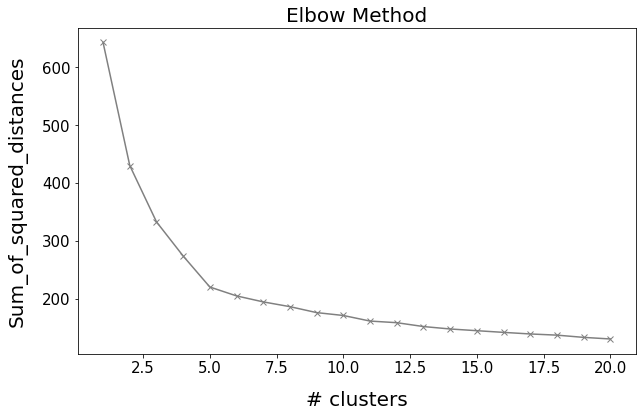

In [82]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
plt.plot(list(range(1,21)),Sum_of_squared_distances,'bx-', color = 'grey')

plt.ylabel('Sum_of_squared_distances', fontsize = 20, labelpad = 15)
plt.xlabel('# clusters', fontsize = 20, labelpad = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Elbow Method", fontsize = 20)

plt.show()
#5 looks to be an appropriate number

/Users/briannamueller/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

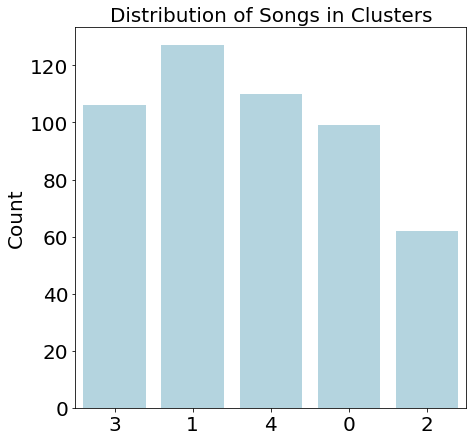

In [83]:
# Choose the number of cluster 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5)
model = kmeans.fit(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))

# See the distribution of songs in each cluster
import seaborn as sns
plt.figure(figsize = (7,7))
sns.countplot([str(group) for group in kmeans.labels_], color = 'lightblue')

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("Distribution of Songs in Clusters", fontsize = 20)
plt.ylabel("Count", fontsize = 20)

The smallest cluster has about 50 songs while the largest cluster has about 180 songs. I think that 50 songs is enough for a playlsit and 180 isn't too many songs for a playlist so I am okay with this k value.

# Visualize the clusters - PCA

Text(0, 0.5, 'PC2: 0.11')

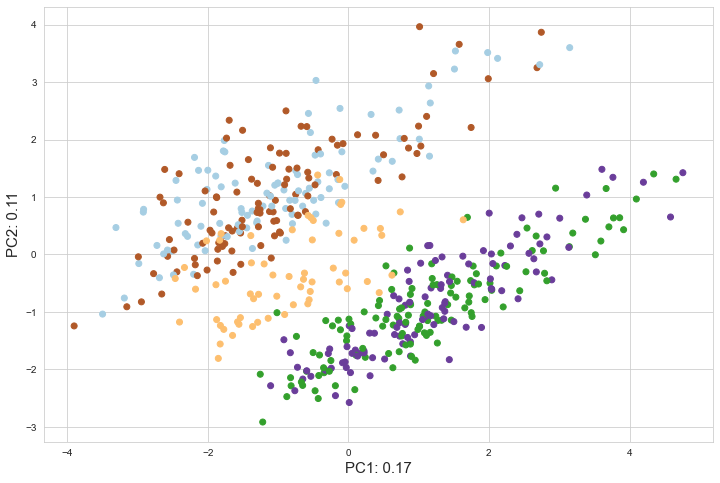

In [84]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))
scaled_data = scaler.transform(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))

from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)

pca_corr = pd.DataFrame(pca.components_, columns = saved_tracks.drop(['artist', 'track', 'id', 'uri'], axis = 1).columns)

sns.set_style('whitegrid')

plt.figure(figsize = (12, 8))
plt.scatter(data_pca[:,0], data_pca[:,1], c = list(kmeans.labels_), cmap = 'Paired')
plt.xlabel('PC1: {:.2f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.2f}'.format(pca.explained_variance_ratio_[1]), size = 15)

It is difficult to distinguish between clusters so this visual doesn't give us much information. We can try a third component.

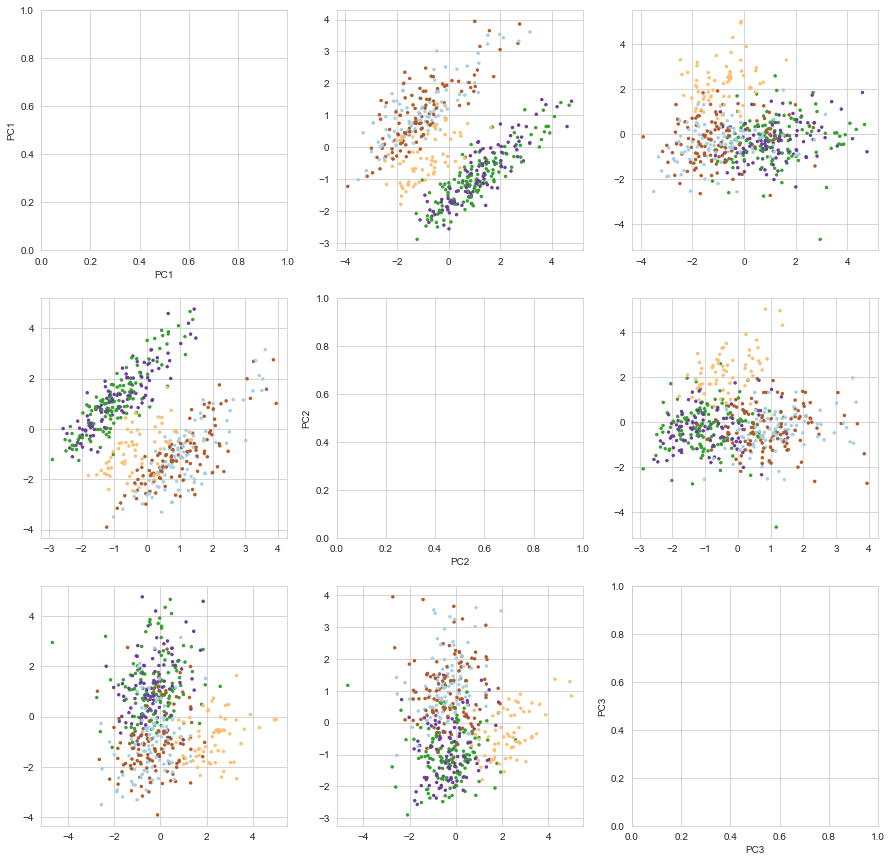

In [85]:
pca = PCA(n_components = 3)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)

sns.set_style('whitegrid')
fig, ax = plt.subplots(3,3,figsize = (15,15), squeeze = False)

for x in range(0,3):
    for y in range(0,3):
        if x != y:
            ax[x, y].scatter(data_pca[:,x], data_pca[:,y], c = list(kmeans.labels_), cmap = 'Paired', s = 6)
        else:
            ax[x,y].set_ylabel('PC{}'.format(x+1))
            ax[x,y].set_xlabel('PC{}'.format(x+1))
            continue

<ipython-input-86-b0d2f4c0afa1>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


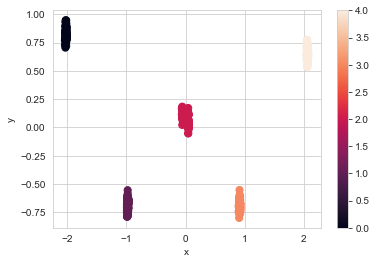

In [86]:
predictions = model.predict(saved_tracks.drop(["artist", "track", "id", "uri"], axis = 1))
saved_tracks['group'] = predictions

pca_result = pca.fit_transform(saved_tracks.drop(['artist', 'track', 'id', 'uri'], axis = 1))
df=pd.DataFrame(pca_result)
df['cluster']= predictions
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(df.iloc[:,0].values, df.iloc[:,1].values,c= predictions,s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

fig.show()

### Look at the attributes of each cluster

In [ ]:
# You can examine each individual cluster
saved_tracks[saved_tracks['group'] == 0].describe()
saved_tracks[saved_tracks['group'] == 1].describe()
saved_tracks[saved_tracks['group'] == 2].describe()
saved_tracks[saved_tracks['group'] == 3].describe()
saved_tracks[saved_tracks['group'] == 4].describe()

There doesn't appear to be any major differences among clusters. This may indicate I don't have a diverse taste for music. Maybe after listening to the songs in each cluster, I will think the clusters make sense.

In [87]:
# Compare cluster means in single dataframe
means = pd.DataFrame(index = range(0,5), 
                    columns = list(saved_tracks[saved_tracks['group'] == 0].describe().loc['mean'].index))
means.iloc[0] = saved_tracks[saved_tracks['group'] == 0].describe().loc['mean']
means.iloc[1] = saved_tracks[saved_tracks['group'] == 1].describe().loc['mean']
means.iloc[2] = saved_tracks[saved_tracks['group'] == 2].describe().loc['mean']
means.iloc[3] = saved_tracks[saved_tracks['group'] == 3].describe().loc['mean']
means.iloc[4] = saved_tracks[saved_tracks['group'] == 4].describe().loc['mean']
means[["danceability", "energy", "liveness", "tempo", "acousticness", "instrumentalness", "key"]]

,danceability,energy,liveness,tempo,acousticness,instrumentalness,key
0,0.613543,0.578831,0.18752,0.394159,0.217909,0.00125879,0.588613
1,0.632817,0.483398,0.180208,0.405815,0.273805,0.010783,0.382963
2,0.70716,0.559019,0.163582,0.47675,0.156375,0.000355081,0.431085
3,0.614094,0.493582,0.163359,0.428944,0.269225,0.00338182,0.51458
4,0.608369,0.603406,0.159985,0.42682,0.171754,0.00904367,0.43719


Initial observations: Cluster 3 has the highest danceability value and cluster 0 has the highest popularity value.

# Create the playlists

In [ ]:
# Get token for authorization 
import spotipy.util as util

username = 
scope = 'playlist-modify-public'
client_id = ''
client_secret = ''
redirect_uri='https://google.com/'
token = util.prompt_for_user_token(username,
                           scope,
                           client_id=client_id,
                           client_secret=client_secret,
                           redirect_uri='https://google.com/')

if token:
    sp = spotipy.Spotify(auth=token)



Creating a playlist requires a user ID which can be found on your Spotify profile page. Select the three dots that appear below your profile picture, select 'Share' and then 'Copy Spotify URI'. 

In [89]:
user = ''

playlist0 = saved_tracks[saved_tracks.group == 0]
playlist1 = saved_tracks[saved_tracks.group == 1]
playlist2 = saved_tracks[saved_tracks.group == 2]
playlist3 = saved_tracks[saved_tracks.group == 3]
playlist4 = saved_tracks[saved_tracks.group == 4]

playlists = ["playlist0", "playlist1", "playlist2", "playlist3", "playlist4"]
playlist_dfs = [playlist0, playlist1, playlist2, playlist3, playlist4]

# Create emtpy playlists
for playlist_name in playlists:
    sp.user_playlist_create(user = user, name=playlist_name)

# Create a dictionary of the user's playlist names and their associated playlistIDs
user_playlists = sp.user_playlists(user = user) 
playlist_dict = {}
for item in user_playlists['items']:
    id = item['id']
    name = item['name']
    playlist_dict[name] = id
    
# From the dictionary, pull the playlistIDs of the playlists we are interested in filling with tracks
playlistIDs = []

for playlist in playlists:
    if playlist in playlist_dict:
        playlistIDs.append(playlist_dict[playlist])


for i in range(len(playlist_dfs)):
    playlist = playlist_dfs[i]
    start = 0
    finish = 50
    while ((len(playlist_dfs[i]) - finish)+50) > 50:
        tracks = list(playlist.id[start:finish])
        sp.user_playlist_add_tracks(user, playlistIDs[i], tracks, position = None)
        start += 50
        finish += 50
    else:
        tracks = list(playlist.id[start:])
        sp.user_playlist_add_tracks(user, playlistIDs[i], tracks, position = None)
        print(f'{len(playlist)} tracks were added to {playlists[i]}.')

99 tracks were added to playlist0.
127 tracks were added to playlist1.
62 tracks were added to playlist2.
106 tracks were added to playlist3.
110 tracks were added to playlist4.


We can now go to Spotify to listen to our new playlists!